# The Packages

In [1]:
# Two models not trained with Eval metrics created

In [2]:
import numpy as np
import pandas as pd
import os
import gc
import datetime
import warnings

In [3]:

import statsmodels.api as sm
from datetime import date

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
import tensorflow as tf
import math 
# keras = tf.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model

In [6]:
tf.__version__

'2.10.1'

In [7]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_style("darkgrid")
sns.color_palette("mako", as_cmap=True)
import plotly.express as px


In [8]:
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# Utility Functions

In [9]:
def plotSeries(time, series, lab,form='-'):
    plt.plot(time, series, form, label=lab)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)

In [10]:
def plotEvaluation(testData, predData, columns):
    testDf = pd.DataFrame(testData, columns = columns)
    predDf = pd.DataFrame(predData, columns = columns)
    plt.figure(figsize=(15,5))
    plt.plot(testDf.Close, label='Real')
    plt.plot(predDf.Close, label='Prediction')

    plt.legend(loc="best")
    #for saving figures
    plt.show()

# The Data

In [11]:
wfc = pd.read_csv('Dataset/Treasury.csv')

In [12]:
wfc.head()

,Date,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
0,2000-01-03,19.56,0,68.61,-4.95,19.56,19.56,19.56,19.56,0.00,0.00,0.00,0.00,50550.00,6050.00
1,2000-01-04,18.59,1,-46.00,-1.01,19.03,19.05,19.07,19.07,0.00,0.00,0.00,0.00,50500.00,6040.00
2,2000-01-05,18.41,2,1.20,4.41,18.78,18.82,18.84,18.85,0.00,0.00,0.00,0.00,50490.00,6051.00
3,2000-01-06,19.22,3,-7.39,1.79,18.92,18.93,18.94,18.94,0.00,0.00,0.00,0.00,50440.00,6046.00
4,2000-01-07,19.56,4,16.11,-3.19,19.11,19.08,19.07,19.07,-0.59,0.00,0.00,0.00,50420.00,6042.00


In [13]:
wfc.Date.dtype

dtype('O')

In [14]:
wfc['Date'] = pd.to_datetime(wfc['Date'])
#wfc.set_index(['Date'],inplace=True)

In [15]:
wfc.head()

,Date,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
0,2000-01-03,19.56,0,68.61,-4.95,19.56,19.56,19.56,19.56,0.00,0.00,0.00,0.00,50550.00,6050.00
1,2000-01-04,18.59,1,-46.00,-1.01,19.03,19.05,19.07,19.07,0.00,0.00,0.00,0.00,50500.00,6040.00
2,2000-01-05,18.41,2,1.20,4.41,18.78,18.82,18.84,18.85,0.00,0.00,0.00,0.00,50490.00,6051.00
3,2000-01-06,19.22,3,-7.39,1.79,18.92,18.93,18.94,18.94,0.00,0.00,0.00,0.00,50440.00,6046.00
4,2000-01-07,19.56,4,16.11,-3.19,19.11,19.08,19.07,19.07,-0.59,0.00,0.00,0.00,50420.00,6042.00


In [16]:
wfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5754 non-null   datetime64[ns]
 1   Close         5754 non-null   float64       
 2   Weekday       5754 non-null   int64         
 3   volumeChange  5754 non-null   float64       
 4   closeChange   5754 non-null   float64       
 5   EMA 10        5754 non-null   float64       
 6   EMA 20        5754 non-null   float64       
 7   EMA 50        5754 non-null   float64       
 8   EMA 100       5754 non-null   float64       
 9   ROC5          5754 non-null   float64       
 10  ROC10         5754 non-null   float64       
 11  ROC15         5754 non-null   float64       
 12  ROC20         5754 non-null   float64       
 13  DTB6          5754 non-null   float64       
 14  DGS5          5754 non-null   float64       
dtypes: datetime64[ns](1), float64(13), int

In [17]:
wfc.describe()

,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
count,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00
mean,36.38,2.02,5.93,0.04,36.36,36.34,36.27,36.16,0.05,0.04,0.04,0.04,6689.76,2101.97
std,11.75,1.40,39.58,2.45,11.71,11.68,11.59,11.45,0.99,0.65,0.52,0.43,13368.12,1528.92
min,8.12,0.00,-84.21,-23.82,10.68,12.45,15.86,17.93,-10.67,-6.28,-4.60,-3.39,0.00,0.00
25%,26.74,1.00,-18.62,-0.84,26.76,26.85,26.86,27.03,-0.34,-0.22,-0.16,-0.13,14.00,1045.00
50%,32.64,2.00,-0.81,0.00,32.47,32.43,32.12,31.70,0.04,0.04,0.04,0.04,1012.00,2031.00
75%,47.79,3.00,20.93,0.86,47.87,47.96,48.12,47.94,0.43,0.30,0.25,0.22,4096.00,3068.00
max,65.93,4.00,480.19,32.76,65.12,64.10,61.54,59.00,11.66,7.05,5.18,3.79,60240.00,6083.00


In [18]:
correlation = wfc.corr ()  
correlation. style.background_gradient ()

,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
Close,1.000000,0.001747,-0.006274,-0.039838,0.996956,0.993631,0.983874,0.968750,0.004187,0.015491,0.022925,0.026540,-0.439516,-0.398083
Weekday,0.001747,1.000000,-0.098591,-0.017046,0.001691,0.001688,0.001563,0.001403,-0.007323,-0.005586,-0.006370,-0.004390,0.006768,0.010420
volumeChange,-0.006274,-0.098591,1.000000,-0.022412,-0.004357,-0.004683,-0.005411,-0.005978,-0.039711,-0.024530,-0.024136,-0.015871,0.002426,0.002252
closeChange,-0.039838,-0.017046,-0.022412,1.000000,-0.033387,-0.031502,-0.029588,-0.027446,0.422185,0.304658,0.236822,0.207675,0.002199,-0.005255
EMA 10,0.996956,0.001691,-0.004357,-0.033387,1.000000,0.998894,0.991294,0.976955,-0.048146,-0.040130,-0.028623,-0.019722,-0.441711,-0.399340
EMA 20,0.993631,0.001688,-0.004683,-0.031502,0.998894,1.000000,0.995826,0.983434,-0.059152,-0.065863,-0.062123,-0.056749,-0.443600,-0.400658
EMA 50,0.983874,0.001563,-0.005411,-0.029588,0.991294,0.995826,1.000000,0.994964,-0.065505,-0.087485,-0.097548,-0.104024,-0.448769,-0.405436
EMA 100,0.968750,0.001403,-0.005978,-0.027446,0.976955,0.983434,0.994964,1.000000,-0.064271,-0.091319,-0.107953,-0.121656,-0.456469,-0.412816
ROC5,0.004187,-0.007323,-0.039711,0.422185,-0.048146,-0.059152,-0.065505,-0.064271,1.000000,0.655172,0.556507,0.453355,0.007238,-0.000947
ROC10,0.015491,-0.005586,-0.024530,0.304658,-0.040130,-0.065863,-0.087485,-0.091319,0.655172,1.000000,0.773739,0.667275,0.007035,-0.003986


In [19]:
#Dropping Volume for Clearer Scale

# The Split

In [20]:
min_date = wfc.Date.min()
max_date = wfc.Date.max()
print("Min:", min_date, "Max:", max_date)

Min: 2000-01-03 00:00:00 Max: 2022-11-11 00:00:00


In [21]:
train_percent = .75
valid_percent = .12

time_between = max_date - min_date

train_cutoff = min_date + train_percent*time_between
valid_cutoff = min_date + (train_percent + valid_percent)*time_between

print("Training Cutoff Date: {:s}".format(str(train_cutoff)))
print("Validation Cutoff Date: {:s}".format(str(valid_cutoff)))

Training Cutoff Date: 2017-02-23 00:00:00
Validation Cutoff Date: 2019-11-21 18:14:24


In [22]:
train_df = wfc[wfc.Date <= train_cutoff]
valid_df = wfc[(wfc.Date > train_cutoff) & (wfc.Date <= valid_cutoff)]
test_df = wfc[wfc.Date > valid_cutoff]


In [23]:
print("Dataset shape: {:s}".format(str(wfc.shape)))
print("Train dataset shape: {:s}".format(str(train_df.shape)))
print("Vaid dataset shape: {:s}".format(str(valid_df.shape)))
print("Test dataset shape: {:s}".format(str(test_df.shape)))

Dataset shape: (5754, 15)
Train dataset shape: (4313, 15)
Vaid dataset shape: (692, 15)
Test dataset shape: (749, 15)


# Stock Price Graph

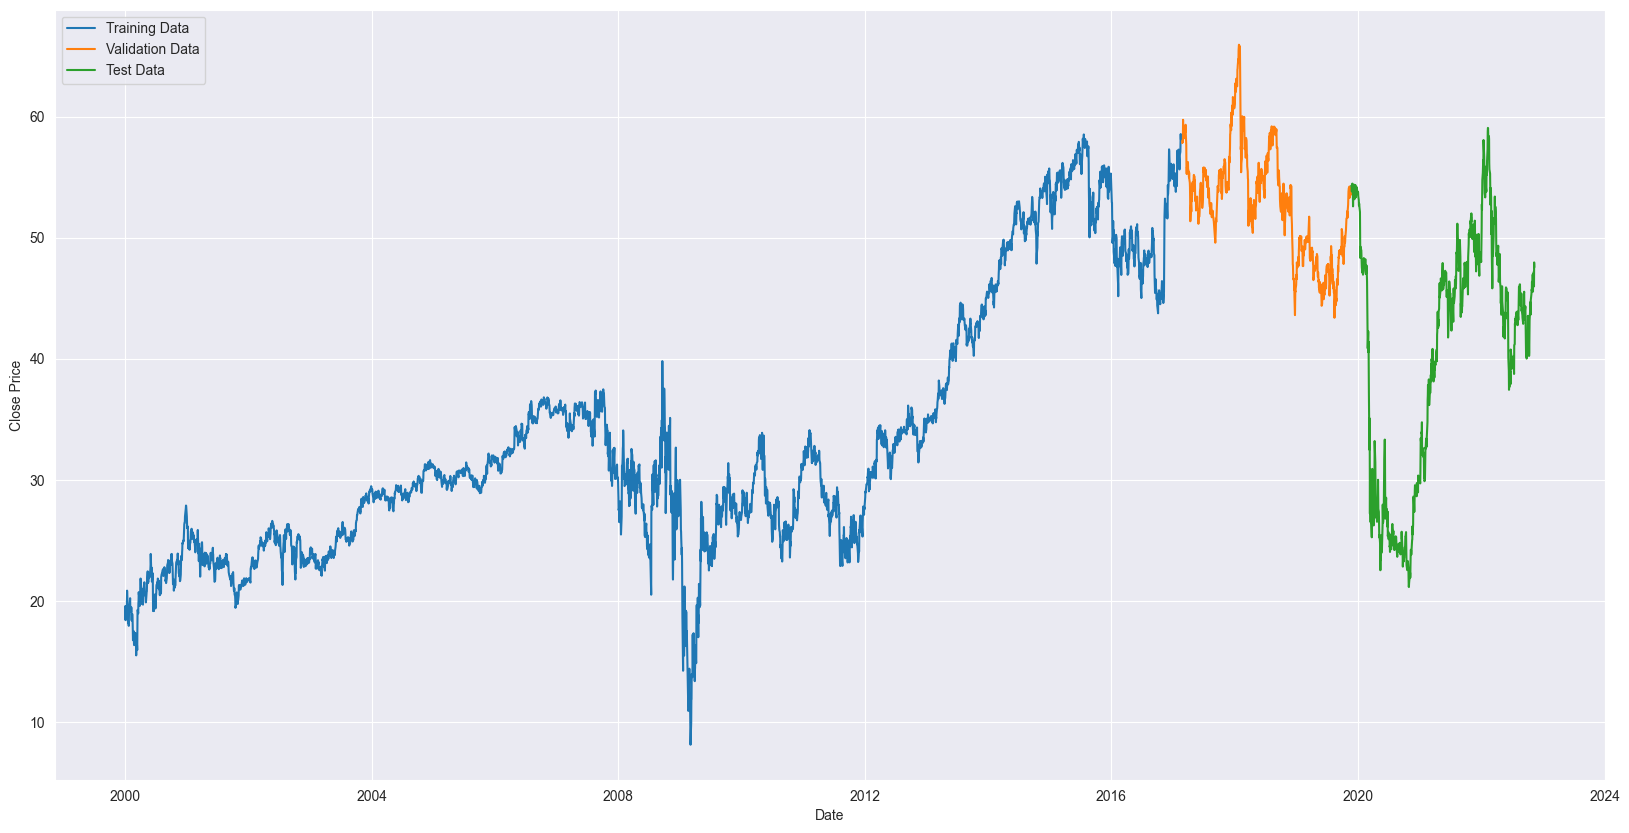

In [24]:
plotSeries(train_df.Date, train_df.Close, "Training Data")
plotSeries(valid_df.Date, valid_df.Close, "Validation Data")
plotSeries(test_df.Date, test_df.Close, "Test Data")
plt.legend(loc='upper left')

# Feature Engineering

In [25]:
train_df.set_index(['Date'],inplace=True)
test_df.set_index(['Date'],inplace=True)
valid_df.set_index(['Date'],inplace=True)

In [26]:
train_df.head()

,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
Date,,,,,,,,,,,,,,
2000-01-03,19.56,0,68.61,-4.95,19.56,19.56,19.56,19.56,0.00,0.00,0.00,0.00,50550.00,6050.00
2000-01-04,18.59,1,-46.00,-1.01,19.03,19.05,19.07,19.07,0.00,0.00,0.00,0.00,50500.00,6040.00
2000-01-05,18.41,2,1.20,4.41,18.78,18.82,18.84,18.85,0.00,0.00,0.00,0.00,50490.00,6051.00
2000-01-06,19.22,3,-7.39,1.79,18.92,18.93,18.94,18.94,0.00,0.00,0.00,0.00,50440.00,6046.00
2000-01-07,19.56,4,16.11,-3.19,19.11,19.08,19.07,19.07,-0.59,0.00,0.00,0.00,50420.00,6042.00


In [27]:
scaler = MinMaxScaler()

trainNorm = scaler.fit_transform(train_df.values)
testNorm = scaler.transform(test_df.values)
validNorm = scaler.transform(valid_df.values)

trainNormDf = pd.DataFrame(trainNorm, columns=train_df.columns)
testNormDf = pd.DataFrame(testNorm, columns=test_df.columns)
validNormDf = pd.DataFrame(validNorm, columns=valid_df.columns)


In [28]:
def splitSequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [29]:
LOOK_BACK = 24
FORECAST_RANGE = 5
n_features = len(trainNormDf.columns)

In [30]:
#Add valid df
Xtrain, Ytrain = splitSequence(trainNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
Xvalid, Yvalid = splitSequence(validNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
Xtest, Ytest = splitSequence(testNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)

In [31]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xvalid.shape)
print(Yvalid.shape)
print(Xtest.shape)
print(Ytest.shape)

(4285, 24, 14)
(4285, 5, 14)
(664, 24, 14)
(664, 5, 14)
(721, 24, 14)
(721, 5, 14)


In [32]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [33]:
def plotMAPEperRange(testData, predData):
    y_test_inverse_time_step  = testData.reshape(int(testData.shape[0]/FORECAST_RANGE), \
                                                      FORECAST_RANGE, testData.shape[-1])
    yhat_inverse_time_step = predData.reshape(int(predData.shape[0]/FORECAST_RANGE), \
                                                  FORECAST_RANGE, predData.shape[-1])
    # yhat_inverse_time_step and y_test_inverse_time_step are both same dimension.
    time_step_list_yhat = [[] for i in range(FORECAST_RANGE)]
    time_step_list_y_test = [[] for i in range(FORECAST_RANGE)]
    for i in range(0, yhat_inverse_time_step.shape[0]):
        for j in range(0, yhat_inverse_time_step.shape[1]):
            time_step_list_yhat[j].append(list(yhat_inverse_time_step[i][j]))
            time_step_list_y_test[j].append(list(y_test_inverse_time_step[i][j]))
    yhat_time_step = np.array(time_step_list_yhat)
    yhat_time_step = yhat_time_step.reshape(yhat_time_step.shape[0], -1)
    y_test_time_step = np.array(time_step_list_y_test)
    y_test_time_step = y_test_time_step.reshape(y_test_time_step.shape[0], -1)
    # plotting
    mape_list = []
    for i in range(0, FORECAST_RANGE):
        mape = mape_(y_test_time_step[i], yhat_time_step[i])
        print(mape)
        mape_list.append(mape)
    plt.plot(range(0, FORECAST_RANGE), mape_list, marker='o')
    plt.xticks((range(0, FORECAST_RANGE)))
    plt.xlabel('Forecast Range')
    plt.ylabel('MAPE')
    

In [34]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)
    

In [35]:
mse_ = tf.keras.losses.MeanSquaredError()
mae_ = tf.keras.losses.MeanAbsoluteError()
mape_ = tf.keras.losses.MeanAbsolutePercentageError()
# mae = mae_(y_test_inverse,yhat_inverse)
# # print('mae:', mae)
# mse = mse_(y_test_inverse,yhat_inverse)
# # print('mse:', mse)
# mape = mape_(y_test_inverse,yhat_inverse)
# # print('mape:', mape)

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Encoder Decoder Model

In [37]:
tf.keras.backend.clear_session()

In [38]:
# WARNING:tensorflow:Layer lstm will not use cuDNN kernels since
# it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
input_layer = Input(shape=(LOOK_BACK, n_features)) 
conv = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
conv = Conv1D(filters=6, kernel_size=11, activation='relu')(conv)
lstm = LSTM(100, return_sequences=True)(conv)
dropout = Dropout(0.2)(lstm)
lstm = LSTM(100)(dropout)
dense = Dense(FORECAST_RANGE*n_features, activation='relu')(lstm)
output_layer = Reshape((FORECAST_RANGE,n_features))(dense)
model_vector_output = Model([input_layer], [output_layer])
model_vector_output.compile(optimizer='adam', loss='mse')


## Tuning Hypertuning LR

In [39]:
lrSchedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)


In [40]:
optimizer = Adam(1e-3)
model_vector_output.compile(loss=tf.keras.losses.MeanSquaredError(),
             optimizer = optimizer,
             metrics = ["mae"])


In [41]:
history = model_vector_output.fit(Xtrain,Ytrain,batch_size=128, epochs=500, callbacks=[lrSchedule, earlyStop])

Epoch 1/500
34/34 [==============================] - 4s 24ms/step - loss: 0.2140 - mae: 0.4042 - lr: 1.0000e-08
Epoch 2/500
34/34 [==============================] - 1s 24ms/step - loss: 0.2140 - mae: 0.4042 - lr: 1.1220e-08
Epoch 3/500
34/34 [==============================] - 1s 24ms/step - loss: 0.2140 - mae: 0.4042 - lr: 1.2589e-08
Epoch 4/500
34/34 [==============================] - 1s 24ms/step - loss: 0.2140 - mae: 0.4042 - lr: 1.4125e-08
Epoch 5/500
34/34 [==============================] - 1s 24ms/step - loss: 0.2140 - mae: 0.4042 - lr: 1.5849e-08
Epoch 6/500
34/34 [==============================] - 1s 23ms/step - loss: 0.2140 - mae: 0.4042 - lr: 1.7783e-08
Epoch 7/500
34/34 [==============================] - 1s 23ms/step - loss: 0.2140 - mae: 0.4042 - lr: 1.9953e-08
Epoch 8/500
34/34 [==============================] - 1s 23ms/step - loss: 0.2140 - mae: 0.4042 - lr: 2.2387e-08
Epoch 9/500
34/34 [==============================] - 1s 23ms/step - loss: 0.2140 - mae: 0.4042 - lr: 2.5

34/34 [==============================] - 1s 24ms/step - loss: 0.0830 - mae: 0.2014 - lr: 3.9811e-05
Epoch 74/500
34/34 [==============================] - 1s 24ms/step - loss: 0.0802 - mae: 0.1962 - lr: 4.4668e-05
Epoch 75/500
34/34 [==============================] - 1s 24ms/step - loss: 0.0764 - mae: 0.1885 - lr: 5.0119e-05
Epoch 76/500
34/34 [==============================] - 1s 24ms/step - loss: 0.0694 - mae: 0.1760 - lr: 5.6234e-05
Epoch 77/500
34/34 [==============================] - 1s 24ms/step - loss: 0.0628 - mae: 0.1629 - lr: 6.3096e-05
Epoch 78/500
34/34 [==============================] - 1s 24ms/step - loss: 0.0605 - mae: 0.1576 - lr: 7.0795e-05
Epoch 79/500
34/34 [==============================] - 1s 24ms/step - loss: 0.0581 - mae: 0.1514 - lr: 7.9433e-05
Epoch 80/500
34/34 [==============================] - 1s 24ms/step - loss: 0.0568 - mae: 0.1471 - lr: 8.9125e-05
Epoch 81/500
34/34 [==============================] - 1s 24ms/step - loss: 0.0563 - mae: 0.1449 - lr: 1.0000e

34/34 [==============================] - 1s 23ms/step - loss: 0.0397 - mae: 0.1268 - lr: 0.1778
Epoch 147/500
34/34 [==============================] - 1s 22ms/step - loss: 0.0396 - mae: 0.1269 - lr: 0.1995
Epoch 148/500
34/34 [==============================] - 1s 22ms/step - loss: 0.0397 - mae: 0.1269 - lr: 0.2239
Epoch 149/500
34/34 [==============================] - 1s 22ms/step - loss: 0.0399 - mae: 0.1274 - lr: 0.2512
Epoch 150/500
34/34 [==============================] - 1s 23ms/step - loss: 0.4506 - mae: 0.3243 - lr: 0.2818
Epoch 151/500
34/34 [==============================] - 1s 23ms/step - loss: 0.2191 - mae: 0.4107 - lr: 0.3162
Epoch 152/500
34/34 [==============================] - 1s 23ms/step - loss: 0.2191 - mae: 0.4107 - lr: 0.3548
Epoch 153/500
34/34 [==============================] - 1s 23ms/step - loss: 0.2191 - mae: 0.4107 - lr: 0.3981
Epoch 154/500
34/34 [==============================] - 1s 22ms/step - loss: 0.2191 - mae: 0.4107 - lr: 0.4467
Epoch 155/500
34/34 [===

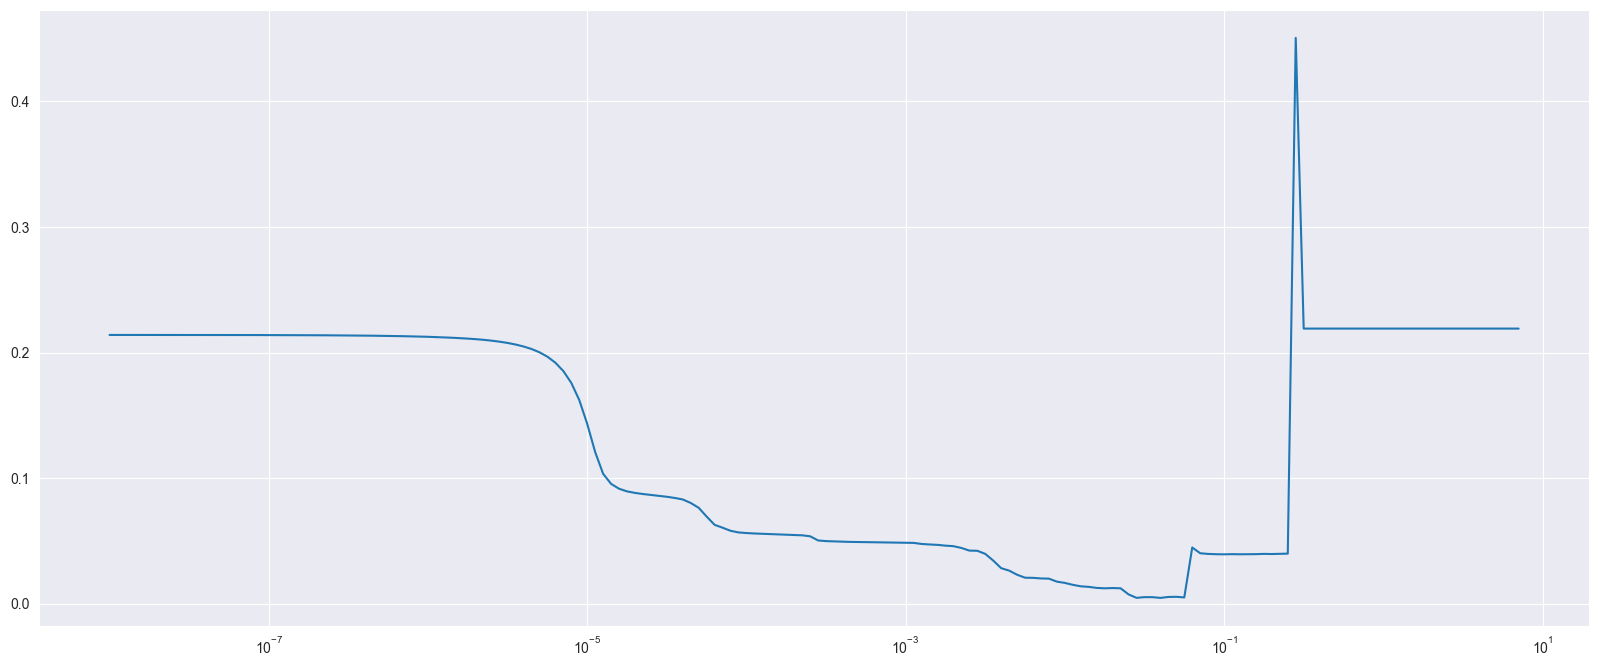

In [42]:
plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])

(0.001, 0.1, 0.0, 0.1)

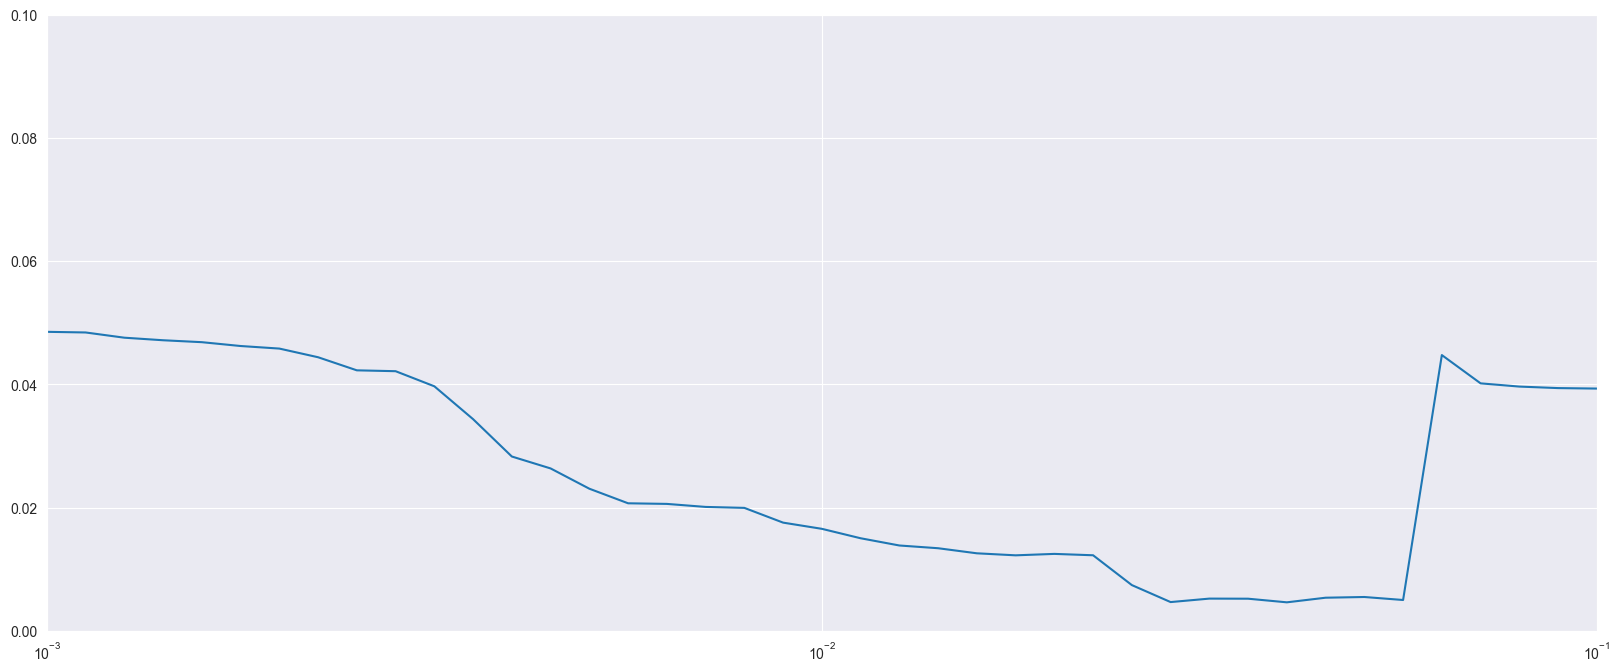

In [46]:
plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-1, 0, 0.1])

## Final Model

In [48]:
model_vector_output.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=Adam(5e-2),
              metrics=['mae'])

In [49]:
# plot_model(model=model_enc_dec, show_shapes=True)

In [50]:
log_dir = "logs\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")
# model_path = ""
tensorboard_callback = [
#                         tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
#                         ModelCheckpoint(model_path, verbose=1, save_best_only=True),
                        ReduceLROnPlateau(monitor='val_mae', factor=0.3,patience=5, min_lr=1e-6, verbose=1),
#                         CSVLogger(csv_path),
                        TensorBoard(),
                        EarlyStopping(monitor= "val_mae", patience=10, restore_best_weights=True)
                       ]

In [52]:
history = model_vector_output.fit(Xtrain, Ytrain,batch_size=128, epochs=100, verbose=1,validation_data=(Xvalid, Yvalid), \
                            callbacks=tensorboard_callback)

Epoch 1/100
34/34 [==============================] - 6s 54ms/step - loss: 0.0704 - mae: 0.1502 - val_loss: 0.0192 - val_mae: 0.0877 - lr: 0.0500
Epoch 2/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0307 - mae: 0.0894 - val_loss: 0.0175 - val_mae: 0.0743 - lr: 0.0500
Epoch 3/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0300 - mae: 0.0842 - val_loss: 0.0167 - val_mae: 0.0699 - lr: 0.0500
Epoch 4/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0299 - mae: 0.0830 - val_loss: 0.0168 - val_mae: 0.0730 - lr: 0.0500
Epoch 5/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0298 - mae: 0.0825 - val_loss: 0.0168 - val_mae: 0.0729 - lr: 0.0500
Epoch 6/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0297 - mae: 0.0822 - val_loss: 0.0163 - val_mae: 0.0690 - lr: 0.0500
Epoch 7/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0281 - mae: 0.0829 - val_loss: 0.0151 - val_mae: 0.070

34/34 [==============================] - 1s 26ms/step - loss: 0.0220 - mae: 0.0627 - val_loss: 0.0092 - val_mae: 0.0506 - lr: 0.0014
Epoch 55/100
34/34 [==============================] - 1s 26ms/step - loss: 0.0220 - mae: 0.0626 - val_loss: 0.0091 - val_mae: 0.0507 - lr: 0.0014
Epoch 56/100
34/34 [==============================] - 1s 26ms/step - loss: 0.0220 - mae: 0.0626 - val_loss: 0.0092 - val_mae: 0.0507 - lr: 0.0014
Epoch 57/100
34/34 [==============================] - 1s 26ms/step - loss: 0.0220 - mae: 0.0626 - val_loss: 0.0091 - val_mae: 0.0507 - lr: 0.0014
Epoch 58/100
34/34 [==============================] - ETA: 0s - loss: 0.0220 - mae: 0.0626
Epoch 58: ReduceLROnPlateau reducing learning rate to 0.00040500001050531865.
34/34 [==============================] - 1s 26ms/step - loss: 0.0220 - mae: 0.0626 - val_loss: 0.0092 - val_mae: 0.0506 - lr: 0.0014
Epoch 59/100
34/34 [==============================] - 1s 25ms/step - loss: 0.0220 - mae: 0.0626 - val_loss: 0.0091 - val_mae: 0

## Keras Score

In [54]:
trainScore = model_vector_output.evaluate(Xtrain, Ytrain, verbose=1)
validScore = model_vector_output.evaluate(Xvalid, Yvalid, verbose=1)
testScore = model_vector_output.evaluate(Xtest, Ytest, verbose=1)

23/23 [==============================] - 0s 4ms/step - loss: 0.0096 - mae: 0.0544


In [55]:
testScore, validScore, trainScore

([0.009592288173735142, 0.05439167469739914],
 [0.00906255841255188, 0.050596967339515686],
 [0.02198474481701851, 0.06190359592437744])

In [57]:
yhat = model_vector_output.predict(Xtest, verbose=0)

In [58]:
predData, testData = inverse_transform(Ytest, yhat)
evaluate_forecast(testData, predData)

mae: tf.Tensor(115.92089, shape=(), dtype=float32)
mse: tf.Tensor(263120.25, shape=(), dtype=float32)
mape: tf.Tensor(205038820.0, shape=(), dtype=float32)


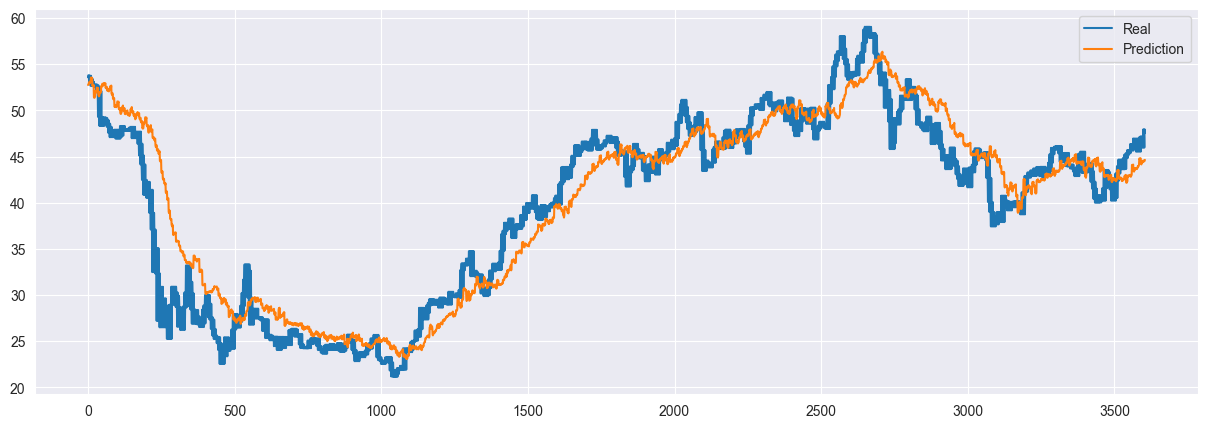

In [59]:
plotEvaluation(testData, predData, columns = testNormDf.columns)

## Ploting The Evaluation

tf.Tensor(4067398.5, shape=(), dtype=float32)
tf.Tensor(4767605.5, shape=(), dtype=float32)
tf.Tensor(991401300.0, shape=(), dtype=float32)
tf.Tensor(5754844.0, shape=(), dtype=float32)
tf.Tensor(19202876.0, shape=(), dtype=float32)


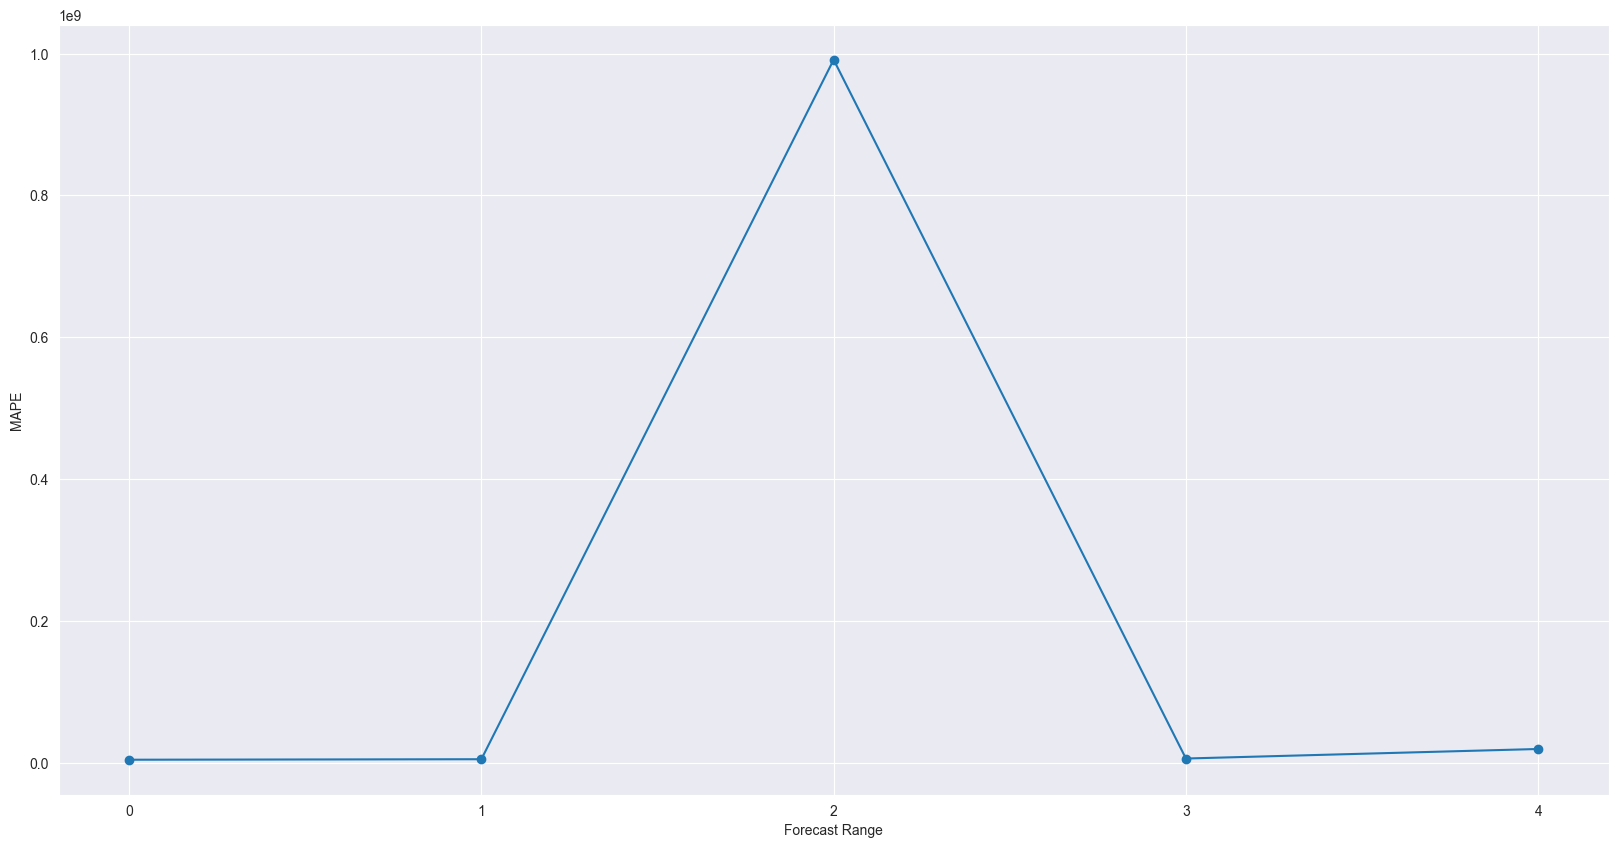

In [60]:
plotMAPEperRange(testData, predData)

In [61]:
def displayMetricsByFeatures(testData, predData, columns):
    for i in range(0, len(columns)):
        print('->', columns[i])
        mae = mae_(testData[:,i],predData[:,i])
        print('mae:', mae)
        mse = mse_(testData[:,i],predData[:,i])
        print('mse:', mse)
        mape = mape_(testData[:,i],predData[:,i])
        print('mape:', mape)

In [62]:
def displayMetricsByColumn(testData, predData, columns, i):

    print('->', columns[i])
    mae = mae_(testData[:,i],predData[:,i])
    print('mae:', mae)
    mse = mse_(testData[:,i],predData[:,i])
    print('mse:', mse)
    mape = mape_(testData[:,i],predData[:,i])
    print('mape:', mape)

In [63]:
displayMetricsByColumn(testData, predData, train_df.columns, 0)

-> Close
mae: tf.Tensor(2.510782, shape=(), dtype=float32)
mse: tf.Tensor(11.656524, shape=(), dtype=float32)
mape: tf.Tensor(6.9405155, shape=(), dtype=float32)


In [64]:
displayMetricsByFeatures(testData, predData, train_df.columns)

-> Close
mae: tf.Tensor(2.510782, shape=(), dtype=float32)
mse: tf.Tensor(11.656524, shape=(), dtype=float32)
mape: tf.Tensor(6.9405155, shape=(), dtype=float32)
-> Weekday
mae: tf.Tensor(0.28748754, shape=(), dtype=float32)
mse: tf.Tensor(0.35559544, shape=(), dtype=float32)
mape: tf.Tensor(82386450.0, shape=(), dtype=float32)
-> volumeChange
mae: tf.Tensor(52.14987, shape=(), dtype=float32)
mse: tf.Tensor(4762.198, shape=(), dtype=float32)
mape: tf.Tensor(23360438.0, shape=(), dtype=float32)
-> closeChange
mae: tf.Tensor(2.0222225, shape=(), dtype=float32)
mse: tf.Tensor(8.349671, shape=(), dtype=float32)
mape: tf.Tensor(1470491.1, shape=(), dtype=float32)
-> EMA 10
mae: tf.Tensor(1.760328, shape=(), dtype=float32)
mse: tf.Tensor(5.6232905, shape=(), dtype=float32)
mape: tf.Tensor(4.853757, shape=(), dtype=float32)
-> EMA 20
mae: tf.Tensor(1.1349194, shape=(), dtype=float32)
mse: tf.Tensor(2.322477, shape=(), dtype=float32)
mape: tf.Tensor(3.145483, shape=(), dtype=float32)
-> EMA 50

# WIP

In [65]:
testData[:20,1]

array([0., 1., 3., 4., 0., 1., 3., 4., 0., 1., 3., 4., 0., 1., 2., 4., 0.,
       1., 2., 3.])

In [66]:
predData[:20,1]

array([0.7334734 , 1.1349504 , 1.8666413 , 2.2907302 , 3.2779937 ,
       1.1407518 , 2.0069027 , 3.0046263 , 3.7195847 , 0.15263808,
       1.962683  , 2.9977145 , 3.756027  , 0.14592572, 1.1968296 ,
       3.0721302 , 3.722796  , 0.        , 1.1293001 , 2.2224627 ],
      dtype=float32)

In [67]:
Ytest.shape

(721, 5, 14)

In [68]:
testData.shape

(3605, 14)

In [69]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE


In [119]:
key = 0
testFore1, testFore2, testFore3, testFore4, testFore5 = list(), list(), list(), list(), list()
predFore1, predFore2, predFore3, predFore4, predFore5 = list(), list(), list(), list(), list()
for i in range(testData.shape[0]): #testData.shape(0)
    remainder = i%5
    if remainder == 0:
        testFore1.append(testData[i][key])
        predFore1.append(predData[i][key])
    elif remainder == 1:
        testFore2.append(testData[i][key])
        predFore2.append(predData[i][key])
    elif remainder == 2:
        testFore3.append(testData[i][key])
        predFore3.append(predData[i][key])
    elif remainder == 3:
        testFore4.append(testData[i][key])
        predFore4.append(predData[i][key])
    elif remainder == 4:
        testFore5.append(testData[i][key])
        predFore5.append(predData[i][key])

In [120]:
len(testFore1), len(testFore5), len(predFore1), len(predFore5)

(721, 721, 721, 721)

In [121]:
evalDict = {"testData1" : testFore1, "testData2" : testFore2, "testData3": testFore3, "testData4" : testFore4, \
                  "testData5" : testFore5, "predData1" : predFore1, "predData2" : predFore2, "predData3": predFore3, \
                  "predData4" : predFore4, "predData5" : predFore5}

In [122]:
evaluationDf = pd.DataFrame(evalDict)
evaluationDf.head()

,testData1,testData2,testData3,testData4,testData5,predData1,predData2,predData3,predData4,predData5
0,53.60,53.80,53.75,53.42,53.10,52.75,52.81,52.83,53.01,52.93
1,53.80,53.75,53.42,53.10,52.66,53.08,53.01,52.98,53.18,53.22
2,53.75,53.42,53.10,52.66,52.82,53.53,53.57,53.50,53.43,53.50
3,53.42,53.10,52.66,52.82,52.73,52.67,52.76,52.65,52.60,52.75
4,53.10,52.66,52.82,52.73,52.50,51.47,51.37,51.37,51.48,51.51


In [123]:
MAPE(evaluationDf.testData1, evaluationDf.predData1)

0.062082878799006445

In [124]:
MAPE(evaluationDf.testData2, evaluationDf.predData2)

0.065785854132945

In [125]:
MAPE(evaluationDf.testData3, evaluationDf.predData3)

0.0694875531760793

In [126]:
MAPE(evaluationDf.testData4, evaluationDf.predData4)

0.07309690556752262

In [127]:
MAPE(evaluationDf.testData5, evaluationDf.predData5)

0.07657256638938939

In [128]:
def average():
    s = (MAPE(evaluationDf.testData1, evaluationDf.predData1) + MAPE(evaluationDf.testData2, evaluationDf.predData2) + \
    MAPE(evaluationDf.testData3, evaluationDf.predData3) + MAPE(evaluationDf.testData4, evaluationDf.predData4) + \
    MAPE(evaluationDf.testData5, evaluationDf.predData5))/5
    print(s)

In [129]:
average()

0.06940515161298855
